In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # Import Model for custom layers/attention
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Bidirectional, Dropout, Input, Permute, multiply, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K # For Keras backend operations
from scikeras.wrappers import KerasClassifier # Wrapper for Keras models in scikit-learn

In [3]:
from scipy.stats import uniform, randint

In [4]:
df = pd.read_csv("comments_df.csv")

In [5]:
df.head()

,comment,sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [6]:
df['comment'] = df['comment'].astype(str)

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150099 entries, 0 to 150098
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    150099 non-null  object
 1   sentiment  150099 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None


In [8]:
df['sentiment'].value_counts()

sentiment
negative    63880
positive    63263
neutral     22956
Name: count, dtype: int64

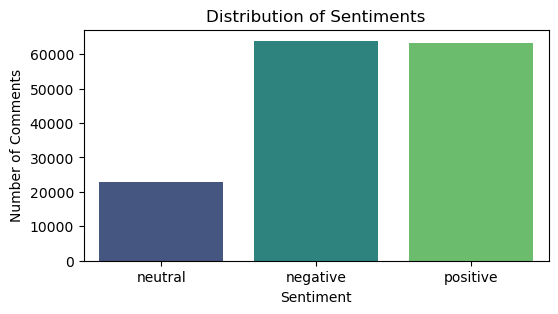

In [9]:
plt.figure(figsize=(6, 3))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

In [10]:
# missing value
df.isnull().sum()

comment      0
sentiment    0
dtype: int64

In [11]:
df['comment_length'] = df['comment'].apply(len)

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


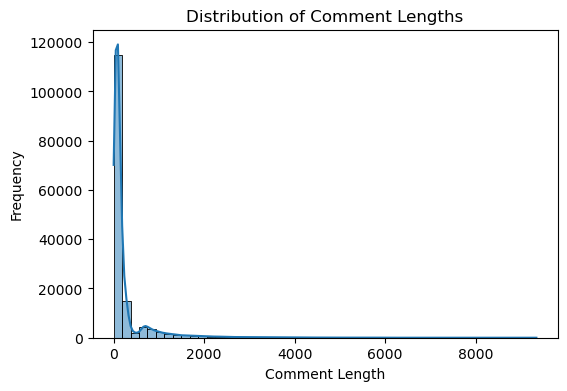

In [12]:
plt.figure(figsize=(6, 4))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
df['comment_length'].mean()

265.13116010100003

In [14]:
df['comment_length'].max()

9345

In [15]:
df['comment_length'].min()

1

In [16]:
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [17]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

negative: 0
neutral: 1
positive: 2


In [18]:
X = df['comment']
y = df['sentiment_encoded'].values
num_classes = len(label_encoder.classes_)

In [19]:
print(f"\nTotal samples: {len(X)}")
print(f"Number of classes: {num_classes}")


Total samples: 150099
Number of classes: 3


In [20]:
vocab_size_rnn_lstm_gru = 10000
max_len_rnn_lstm_gru = 100 # Max length for padding sequences
embedding_dim_rnn_lstm_gru = 128 # Embedding dimension for all these models

In [21]:
tokenizer_rnn_lstm_gru = Tokenizer(num_words=vocab_size_rnn_lstm_gru, oov_token="<OOV>")
tokenizer_rnn_lstm_gru.fit_on_texts(X) # Fit on 'comment' column

In [22]:
sequences_rnn_lstm_gru = tokenizer_rnn_lstm_gru.texts_to_sequences(X) # Convert 'comment' to sequences
X_padded_rnn_lstm_gru = pad_sequences(sequences_rnn_lstm_gru, maxlen=max_len_rnn_lstm_gru, padding='post', truncating='post')

In [23]:
# Split data for all RNN/LSTM/GRU models
X_train_rnn_lstm_gru, X_test_rnn_lstm_gru, y_train_rnn_lstm_gru, y_test_rnn_lstm_gru = train_test_split(
    X_padded_rnn_lstm_gru, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
print(X_train_rnn_lstm_gru.shape)
print(X_test_rnn_lstm_gru.shape)
print(y_train_rnn_lstm_gru.shape)
print(y_test_rnn_lstm_gru.shape)

(120079, 100)
(30020, 100)
(120079,)
(30020,)


In [25]:
# Helper function for plotting training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [26]:
# Custom Attention Layer (Bahdanau-style)
# This layer learns to weigh the importance of different parts of the input sequence.
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape is (batch_size, sequence_length, features)
        # W is the weight matrix for the attention mechanism, applied to the input features.
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        # b is the bias vector for the attention mechanism, applied across the sequence length.
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x is (batch_size, sequence_length, features)
        # Apply a dense layer (dot product with W + bias b) to get scores for each timestep
        # K.tanh is used as the activation function for the scoring mechanism.
        e = K.tanh(K.dot(x, self.W) + self.b) # Output shape: (batch_size, sequence_length, 1)
        # Squeeze the last dimension to get (batch_size, sequence_length)
        e = K.squeeze(e, axis=-1) # Output shape: (batch_size, sequence_length)

        # Apply softmax to get attention weights. These weights sum to 1 across the sequence.
        alpha = K.softmax(e) # Output shape: (batch_size, sequence_length)

        # Reshape alpha to (batch_size, sequence_length, 1) for element-wise multiplication with input x
        alpha = K.expand_dims(alpha, axis=-1)

        # Multiply the attention weights by the input sequence. This re-weights each word's features.
        output = x * alpha # Output shape: (batch_size, sequence_length, features)

        # Sum over the sequence length (axis=1) to get the context vector.
        # This context vector is a weighted sum of the input features, emphasizing important words.
        output = K.sum(output, axis=1) # Output shape: (batch_size, features)
        return output

    def get_config(self):
        # This is necessary for saving/loading models that include custom layers
        return super(Attention, self).get_config()

In [27]:
# Define Early Stopping callback for individual model training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [28]:
# Deep BiLSTM Model with Attention
# This model uses two stacked BiLSTM layers
def create_deep_bilstm_model(learning_rate=0.001, dropout_rate=0.3, lstm_units_1=64, lstm_units_2=32):
    lstm_input = Input(shape=(max_len_rnn_lstm_gru,))
    lstm_embedding = Embedding(vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru, input_length=max_len_rnn_lstm_gru)(lstm_input)

    # First Bidirectional LSTM layer, returns full sequences
    lstm_layer_1 = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(lstm_embedding)
    lstm_dropout_1 = Dropout(dropout_rate)(lstm_layer_1)
    # Second Bidirectional LSTM layer, returns full sequences for attention
    lstm_layer_2 = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(lstm_dropout_1)
    lstm_dropout_2 = Dropout(dropout_rate)(lstm_layer_2)

    # Applying Attention mechanism to the output of the last recurrent layer
    attention_output = Attention()(lstm_dropout_2)

    # Final dense layer for classification
    lstm_output = Dense(num_classes, activation='softmax')(attention_output)

    model = Model(inputs=lstm_input, outputs=lstm_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
# Deep SimpleRNN Model with Attention
def create_deep_rnn_model(learning_rate=0.001, dropout_rate=0.3, rnn_units_1=64, rnn_units_2=32):
    """
    Creates a Deep SimpleRNN model with an Attention mechanism.
    This model uses two stacked SimpleRNN layers.
    """
    rnn_input = Input(shape=(max_len_rnn_lstm_gru,))
    rnn_embedding = Embedding(vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru, input_length=max_len_rnn_lstm_gru)(rnn_input)

    # First SimpleRNN layer, returns full sequences
    rnn_layer_1 = SimpleRNN(rnn_units_1, return_sequences=True)(rnn_embedding)
    rnn_dropout_1 = Dropout(dropout_rate)(rnn_layer_1)
    # Second SimpleRNN layer, returns full sequences for attention
    rnn_layer_2 = SimpleRNN(rnn_units_2, return_sequences=True)(rnn_dropout_1)
    rnn_dropout_2 = Dropout(dropout_rate)(rnn_layer_2)

    # Apply Attention mechanism
    attention_output_rnn = Attention()(rnn_dropout_2)

    # Final dense layer for classification
    rnn_output = Dense(num_classes, activation='softmax')(attention_output_rnn)

    model = Model(inputs=rnn_input, outputs=rnn_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# Stacked LSTM Model with Attention (Unidirectional)
def create_stacked_lstm_model(learning_rate=0.001, dropout_rate=0.3, lstm_units_1=64, lstm_units_2=32):
    """
    Creates a Stacked Unidirectional LSTM model with an Attention mechanism.
    """
    lstm_input = Input(shape=(max_len_rnn_lstm_gru,))
    lstm_embedding = Embedding(vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru, input_length=max_len_rnn_lstm_gru)(lstm_input)

    # First LSTM layer, returns full sequences
    lstm_layer_1 = LSTM(lstm_units_1, return_sequences=True)(lstm_embedding)
    lstm_dropout_1 = Dropout(dropout_rate)(lstm_layer_1)
    # Second LSTM layer, returns full sequences for attention
    lstm_layer_2 = LSTM(lstm_units_2, return_sequences=True)(lstm_dropout_1)
    lstm_dropout_2 = Dropout(dropout_rate)(lstm_layer_2)

    # Apply Attention mechanism
    attention_output = Attention()(lstm_dropout_2)

    # Final dense layer for classification
    lstm_output = Dense(num_classes, activation='softmax')(attention_output)

    model = Model(inputs=lstm_input, outputs=lstm_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
# GRU Model with Attention (Single Layer)
def create_gru_model(learning_rate=0.001, dropout_rate=0.3, gru_units=64):
    """
    Creates a single-layer GRU model with an Attention mechanism.
    """
    gru_input = Input(shape=(max_len_rnn_lstm_gru,))
    gru_embedding = Embedding(vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru, input_length=max_len_rnn_lstm_gru)(gru_input)

    # Single GRU layer, returns full sequences for attention
    gru_layer = GRU(gru_units, return_sequences=True)(gru_embedding)
    gru_dropout = Dropout(dropout_rate)(gru_layer)

    # Apply Attention mechanism
    attention_output_gru = Attention()(gru_dropout)

    # Final dense layer for classification
    gru_output = Dense(num_classes, activation='softmax')(attention_output_gru)

    model = Model(inputs=gru_input, outputs=gru_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
# Stacked GRU Model with Attention
def create_stacked_gru_model(learning_rate=0.001, dropout_rate=0.3, gru_units_1=64, gru_units_2=32):
    """
    Creates a Stacked GRU model with an Attention mechanism.
    This model uses two stacked GRU layers.
    """
    gru_input = Input(shape=(max_len_rnn_lstm_gru,))
    gru_embedding = Embedding(vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru, input_length=max_len_rnn_lstm_gru)(gru_input)

    # First GRU layer, returns full sequences
    gru_layer_1 = GRU(gru_units_1, return_sequences=True)(gru_embedding)
    gru_dropout_1 = Dropout(dropout_rate)(gru_layer_1)
    # Second GRU layer, returns full sequences for attention
    gru_layer_2 = GRU(gru_units_2, return_sequences=True)(gru_dropout_1)
    gru_dropout_2 = Dropout(dropout_rate)(gru_layer_2)

    # Apply Attention mechanism
    attention_output_gru = Attention()(gru_dropout_2)

    # Final dense layer for classification
    gru_output = Dense(num_classes, activation='softmax')(attention_output_gru)

    model = Model(inputs=gru_input, outputs=gru_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
# 4. Sequential Model Training, Tuning, and Evaluation

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,391 (5.42 MB)

 Trainable params: 1,420,391 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 936s 530ms/step - accuracy: 0.5841 - loss: 0.8348 - val_accuracy: 0.7444 - val_loss: 0.6001
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 856s 507ms/step - accuracy: 0.7818 - loss: 0.5275 - val_accuracy: 0.7623 - val_loss: 0.5598
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 725s 429ms/step - accuracy: 0.8279 - loss: 0.4213 - val_accuracy: 0.7745 - val_loss: 0.5516
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 774s 458ms/step - accuracy: 0.8604 - loss: 0.3440 - val_accuracy: 0.7771 - val_loss: 0.5645
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 762s 434ms/step - accuracy: 0.8880 - loss: 0.2799 - val_accuracy: 0.7792 - val_loss: 0.6211
Restoring model weights from the end of the best epoch: 3.
Initial Deep BiLSTM Test Loss: 0.5574
Initial Deep BiLSTM Test Accuracy: 0.7721


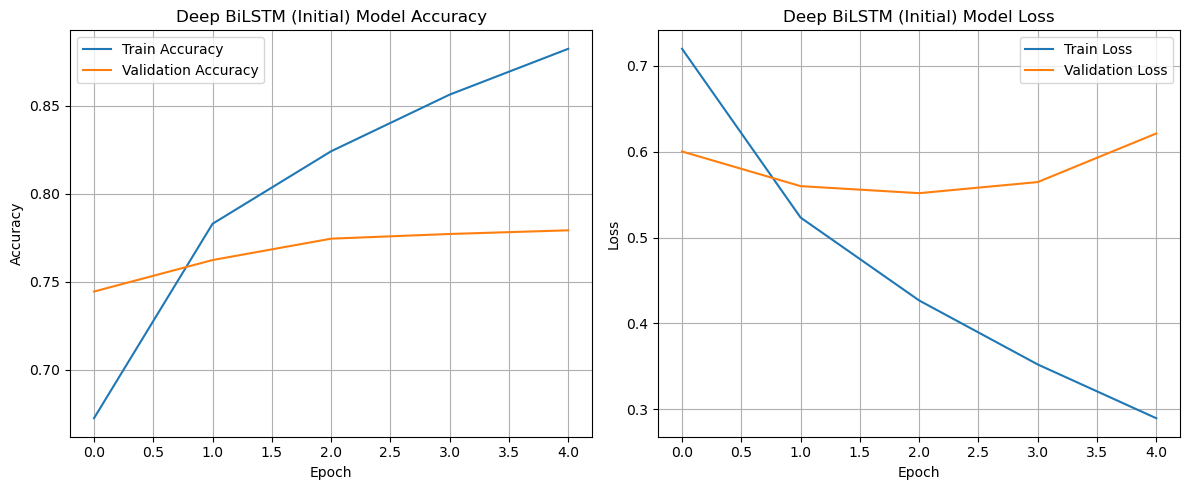

In [59]:
# 4.1 Deep BiLSTM Model with Attention
# Initial Training with Default Parameters
initial_bilstm_model = create_deep_bilstm_model() # Using default parameters
initial_bilstm_model.summary()

history_initial_bilstm = initial_bilstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_bilstm, accuracy_initial_bilstm = initial_bilstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Deep BiLSTM Test Loss: {loss_initial_bilstm:.4f}")
print(f"Initial Deep BiLSTM Test Accuracy: {accuracy_initial_bilstm:.4f}")
plot_training_history(history_initial_bilstm, 'Deep BiLSTM (Initial)')


In [34]:
# Hyperparameter Tuning Setup (Subset for faster tuning)
tuning_subset_size = min(10000, len(X_train_rnn_lstm_gru)) # Use up to 10,000 samples for tuning
X_tune = X_train_rnn_lstm_gru[:tuning_subset_size]
y_tune = y_train_rnn_lstm_gru[:tuning_subset_size]

In [35]:
# Hyperparameter Tuning for Deep BiLSTM
bilstm_classifier = KerasClassifier(model=create_deep_bilstm_model, verbose=0)
param_dist_bilstm = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__lstm_units_1': randint(32, 96),
    'model__lstm_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_bilstm = RandomizedSearchCV(
    estimator=bilstm_classifier, param_distributions=param_dist_bilstm,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_bilstm.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_bilstm.best_score_:.4f}")
print(f"Best Parameters: {random_search_bilstm.best_params_}")
best_bilstm_model_params = random_search_bilstm.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time=13.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time=14.1min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 9.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 8.5min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 5.6min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 5.4min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6307
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.24679835610086082, 'model__learning_rate': 0.00015808361216819946, 'model__lstm_units_1': 55, 'model__lstm_units_2': 36}



Building and Training Deep BiLSTM Model with Best Parameters (Final Run)...


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 100, 110)       │        80,960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 110)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100, 72)        │        42,336 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 72)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_7 (Attention)         │ (None, 72)             │           172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,687 (5.35 MB)

 Trainable params: 1,403,687 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 980s 280ms/step - accuracy: 0.5281 - loss: 0.9025 - val_accuracy: 0.7188 - val_loss: 0.6592
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 945s 269ms/step - accuracy: 0.7522 - loss: 0.5996 - val_accuracy: 0.7345 - val_loss: 0.6219
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 926s 274ms/step - accuracy: 0.7732 - loss: 0.5509 - val_accuracy: 0.7443 - val_loss: 0.6045
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 512s 152ms/step - accuracy: 0.7938 - loss: 0.5100 - val_accuracy: 0.7480 - val_loss: 0.6011
Epoch 5/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 968s 286ms/step - accuracy: 0.8041 - loss: 0.4838 - val_accuracy: 0.7508 - val_loss: 0.5946
Epoch 6/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1064s 311ms/step - accuracy: 0.8179 - loss: 0.4497 - val_accuracy: 0.7498 - val_loss: 0.6097
Epoch 7/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 966s 286ms/step - accuracy: 0.8320 - loss: 0.4168 - val_accuracy: 0.7597 - val_loss: 0.5985
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 499s 148ms/step - a

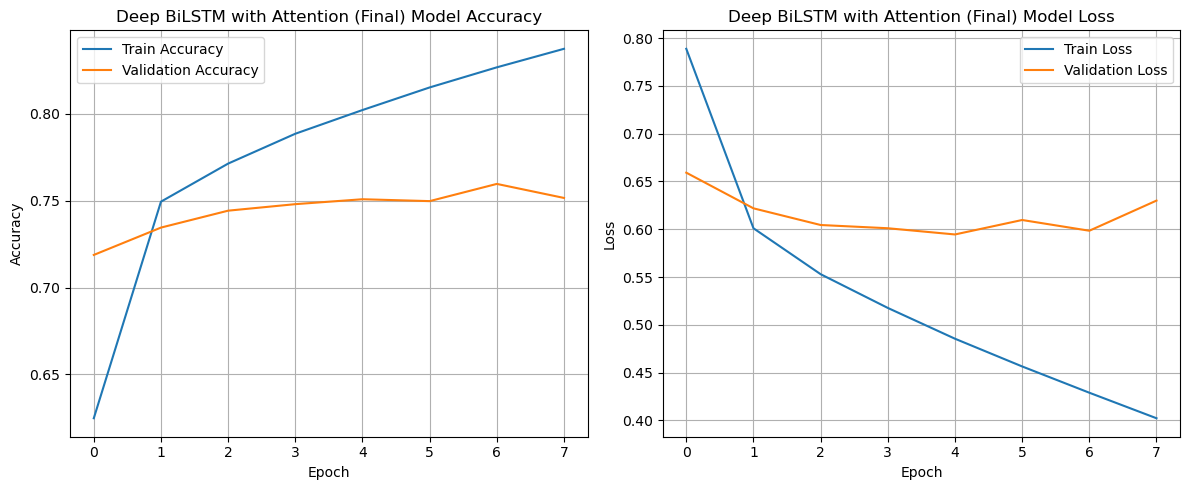

In [36]:
# Final Training with Best Parameters for Deep BiLSTM
print("\nBuilding and Training Deep BiLSTM Model with Best Parameters (Final Run)...")
final_bilstm_model = create_deep_bilstm_model(
    learning_rate=best_bilstm_model_params['model__learning_rate'],
    dropout_rate=best_bilstm_model_params['model__dropout_rate'],
    lstm_units_1=best_bilstm_model_params['model__lstm_units_1'],
    lstm_units_2=best_bilstm_model_params['model__lstm_units_2']
)
final_bilstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_bilstm_model_params['model__learning_rate']),
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_bilstm_model.summary()

history_final_bilstm = final_bilstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10, # Full epochs for final run
    batch_size=best_bilstm_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

loss_final_bilstm, accuracy_final_bilstm = final_bilstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Deep BiLSTM Test Loss: {loss_final_bilstm:.4f}")
print(f"Final Deep BiLSTM Test Accuracy: {accuracy_final_bilstm:.4f}")
y_pred_final_bilstm = np.argmax(final_bilstm_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_bilstm, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_bilstm))
plot_training_history(history_final_bilstm, 'Deep BiLSTM with Attention (Final)')

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_8 (Attention)         │ (None, 32)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,055 (5.12 MB)

 Trainable params: 1,342,055 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 280s 162ms/step - accuracy: 0.5977 - loss: 0.8265 - val_accuracy: 0.7303 - val_loss: 0.6266
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 291s 144ms/step - accuracy: 0.7782 - loss: 0.5357 - val_accuracy: 0.7639 - val_loss: 0.5593
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 242s 143ms/step - accuracy: 0.8276 - loss: 0.4213 - val_accuracy: 0.7783 - val_loss: 0.5392
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 240s 142ms/step - accuracy: 0.8624 - loss: 0.3390 - val_accuracy: 0.7836 - val_loss: 0.5564
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 261s 141ms/step - accuracy: 0.8902 - loss: 0.2718 - val_accuracy: 0.7827 - val_loss: 0.6137
Restoring model weights from the end of the best epoch: 3.
Initial Stacked LSTM Test Loss: 0.5470
Initial Stacked LSTM Test Accuracy: 0.7763


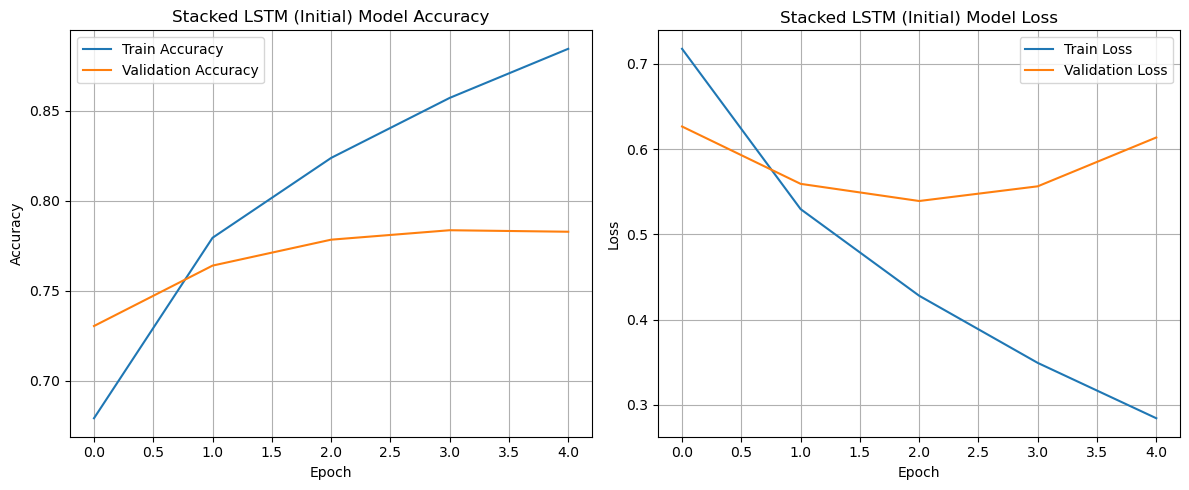

In [40]:
# Stacked LSTM Model with Attention
# Initial Training with Default Parameters
initial_stacked_lstm_model = create_stacked_lstm_model() # Using default parameters
initial_stacked_lstm_model.summary()

history_initial_stacked_lstm = initial_stacked_lstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_stacked_lstm, accuracy_initial_stacked_lstm = initial_stacked_lstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Stacked LSTM Test Loss: {loss_initial_stacked_lstm:.4f}")
print(f"Initial Stacked LSTM Test Accuracy: {accuracy_initial_stacked_lstm:.4f}")
plot_training_history(history_initial_stacked_lstm, 'Stacked LSTM (Initial)')


In [41]:
# Hyperparameter Tuning for Stacked LSTM
stacked_lstm_classifier = KerasClassifier(model=create_stacked_lstm_model, verbose=0)
param_dist_stacked_lstm = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__lstm_units_1': randint(32, 96),
    'model__lstm_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_stacked_lstm = RandomizedSearchCV(
    estimator=stacked_lstm_classifier, param_distributions=param_dist_stacked_lstm,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_stacked_lstm.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_stacked_lstm.best_score_:.4f}")
print(f"Best Parameters: {random_search_stacked_lstm.best_params_}")
best_stacked_lstm_model_params = random_search_stacked_lstm.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time= 5.6min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time= 5.9min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 6.1min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 5.9min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 2.9min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 2.7min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6412
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.24679835610086082, 'model__learning_rate': 0.00015808361216819946, 'model__lstm_units_1': 55, 'model__lstm_units_2': 36}


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 100, 55)        │        40,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 100, 55)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 100, 36)        │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 100, 36)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_16 (Attention)        │ (None, 36)             │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,333,975 (5.09 MB)

 Trainable params: 1,333,975 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 920s 267ms/step - accuracy: 0.5341 - loss: 0.9048 - val_accuracy: 0.7178 - val_loss: 0.6666
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 882s 261ms/step - accuracy: 0.7494 - loss: 0.6111 - val_accuracy: 0.7330 - val_loss: 0.6307
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 871s 258ms/step - accuracy: 0.7726 - loss: 0.5601 - val_accuracy: 0.7378 - val_loss: 0.6195
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 779s 230ms/step - accuracy: 0.7953 - loss: 0.5038 - val_accuracy: 0.7457 - val_loss: 0.6057
Epoch 6/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 383s 113ms/step - accuracy: 0.8084 - loss: 0.4778 - val_accuracy: 0.7489 - val_loss: 0.6009
Epoch 7/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 379s 112ms/step - accuracy: 0.8211 - loss: 0.4495 - val_accuracy: 0.7571 - val_loss: 0.6118
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 401s 119ms/step - accuracy: 0.8350 - loss: 0.4176 - val_accuracy: 0.7583 - val_loss: 0.6050
Epoch 9/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 381s 113ms/step - ac

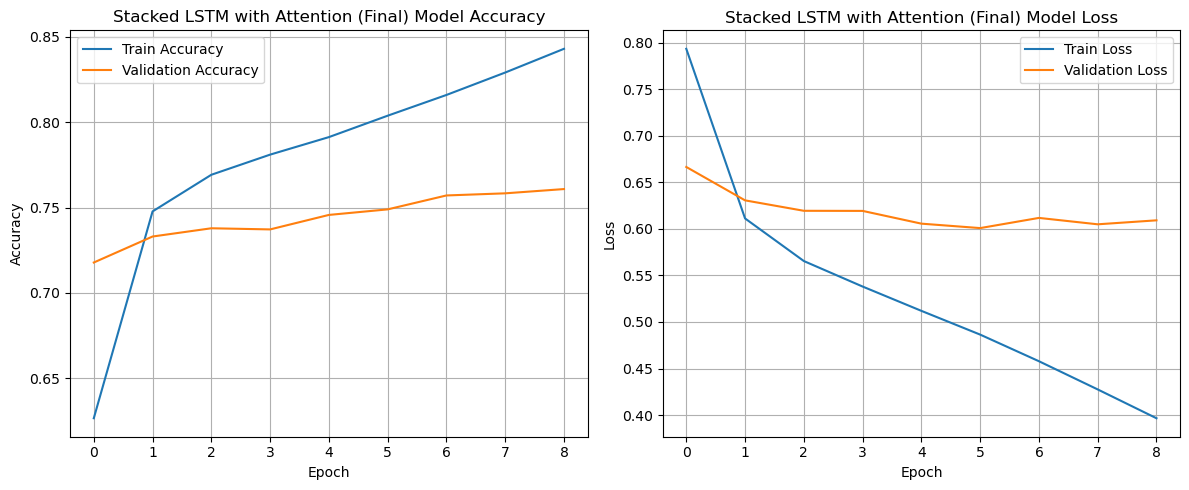

In [42]:
# Final Training with Best Parameters for Stacked LSTM
final_stacked_lstm_model = create_stacked_lstm_model(
    learning_rate=best_stacked_lstm_model_params['model__learning_rate'],
    dropout_rate=best_stacked_lstm_model_params['model__dropout_rate'],
    lstm_units_1=best_stacked_lstm_model_params['model__lstm_units_1'],
    lstm_units_2=best_stacked_lstm_model_params['model__lstm_units_2']
)
final_stacked_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_stacked_lstm_model_params['model__learning_rate']),
                                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_stacked_lstm_model.summary()

history_final_stacked_lstm = final_stacked_lstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10,
    batch_size=best_stacked_lstm_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_final_stacked_lstm, accuracy_final_stacked_lstm = final_stacked_lstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Stacked LSTM Test Loss: {loss_final_stacked_lstm:.4f}")
print(f"Final Stacked LSTM Test Accuracy: {accuracy_final_stacked_lstm:.4f}")
y_pred_final_stacked_lstm = np.argmax(final_stacked_lstm_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_stacked_lstm, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_stacked_lstm))
plot_training_history(history_final_stacked_lstm, 'Stacked LSTM with Attention (Final)')

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_17 (Attention)        │ (None, 32)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,295,687 (4.94 MB)

 Trainable params: 1,295,687 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 199s 112ms/step - accuracy: 0.6098 - loss: 0.8253 - val_accuracy: 0.7346 - val_loss: 0.6238
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 187s 111ms/step - accuracy: 0.7673 - loss: 0.5633 - val_accuracy: 0.7432 - val_loss: 0.5982
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 188s 111ms/step - accuracy: 0.7963 - loss: 0.4949 - val_accuracy: 0.7554 - val_loss: 0.5890
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 191s 113ms/step - accuracy: 0.8233 - loss: 0.4364 - val_accuracy: 0.7608 - val_loss: 0.5769
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 196s 116ms/step - accuracy: 0.8452 - loss: 0.3853 - val_accuracy: 0.7521 - val_loss: 0.6076
Restoring model weights from the end of the best epoch: 4.
Initial Deep SimpleRNN Test Loss: 0.5870
Initial Deep SimpleRNN Test Accuracy: 0.7603


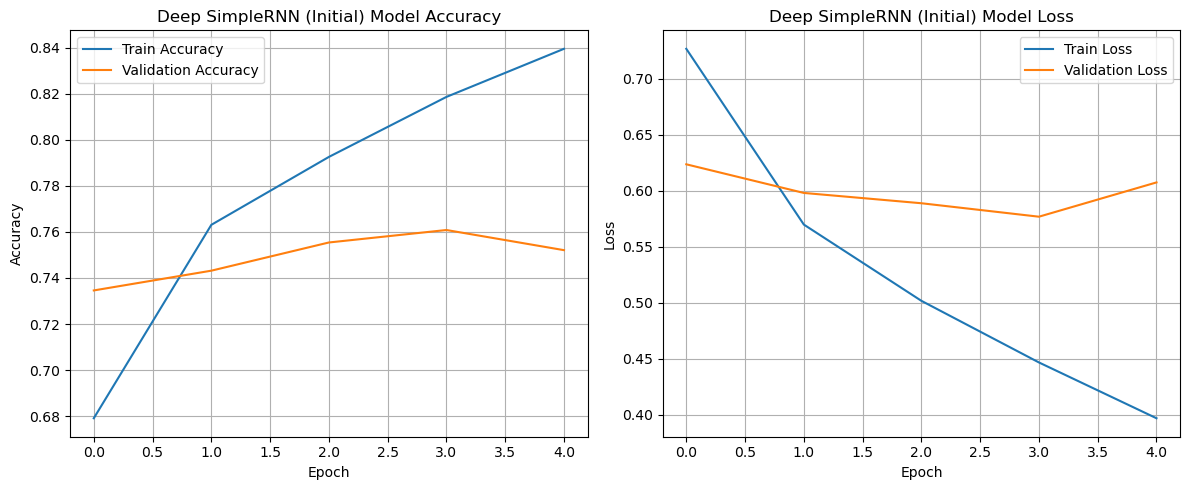

In [43]:
# Deep SimpleRNN Model with Attention
# Initial Training with Default Parameters
initial_rnn_model = create_deep_rnn_model() # Using default parameters
initial_rnn_model.summary()

history_initial_rnn = initial_rnn_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_rnn, accuracy_initial_rnn = initial_rnn_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Deep SimpleRNN Test Loss: {loss_initial_rnn:.4f}")
print(f"Initial Deep SimpleRNN Test Accuracy: {accuracy_initial_rnn:.4f}")
plot_training_history(history_initial_rnn, 'Deep SimpleRNN (Initial)')

In [45]:
# Hyperparameter Tuning for Deep SimpleRNN
rnn_classifier = KerasClassifier(model=create_deep_rnn_model, verbose=0)
param_dist_rnn = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__rnn_units_1': randint(32, 96),
    'model__rnn_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_rnn = RandomizedSearchCV(
    estimator=rnn_classifier, param_distributions=param_dist_rnn,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_rnn.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_rnn.best_score_:.4f}")
print(f"Best Parameters: {random_search_rnn.best_params_}")
best_rnn_model_params = random_search_rnn.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__rnn_units_1=92, model__rnn_units_2=36; total time= 3.1min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__rnn_units_1=92, model__rnn_units_2=36; total time= 3.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__rnn_units_1=55, model__rnn_units_2=36; total time= 2.8min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__rnn_units_1=55, model__rnn_units_2=36; total time= 2.7min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__rnn_units_1=33, model__rnn_units_2=39; total time= 1.7min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__rnn_units_1=33, model__rnn_units_2=39; total time= 1.7min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6042
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.24679835610086082, 'model__learning_rate': 0.00015808361216819946, 'model__rnn_units_1': 55, 'model__rnn_units_2': 36}


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_32 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (None, 100, 55)        │        10,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 100, 55)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ (None, 100, 36)        │         3,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 100, 36)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_30 (Attention)        │ (None, 36)             │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,293,679 (4.93 MB)

 Trainable params: 1,293,679 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 318s 92ms/step - accuracy: 0.5543 - loss: 0.8896 - val_accuracy: 0.7099 - val_loss: 0.6716
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 326s 96ms/step - accuracy: 0.7489 - loss: 0.6106 - val_accuracy: 0.7346 - val_loss: 0.6284
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 199s 42ms/step - accuracy: 0.7762 - loss: 0.5457 - val_accuracy: 0.7333 - val_loss: 0.6194
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 188s 56ms/step - accuracy: 0.8000 - loss: 0.4929 - val_accuracy: 0.7333 - val_loss: 0.6341
Epoch 5/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 219s 65ms/step - accuracy: 0.8204 - loss: 0.4524 - val_accuracy: 0.7354 - val_loss: 0.6313
Epoch 6/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 251s 74ms/step - accuracy: 0.8365 - loss: 0.4122 - val_accuracy: 0.7457 - val_loss: 0.6076
Epoch 7/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 224s 66ms/step - accuracy: 0.8519 - loss: 0.3776 - val_accuracy: 0.7476 - val_loss: 0.6344
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 218s 65ms/step - accuracy: 

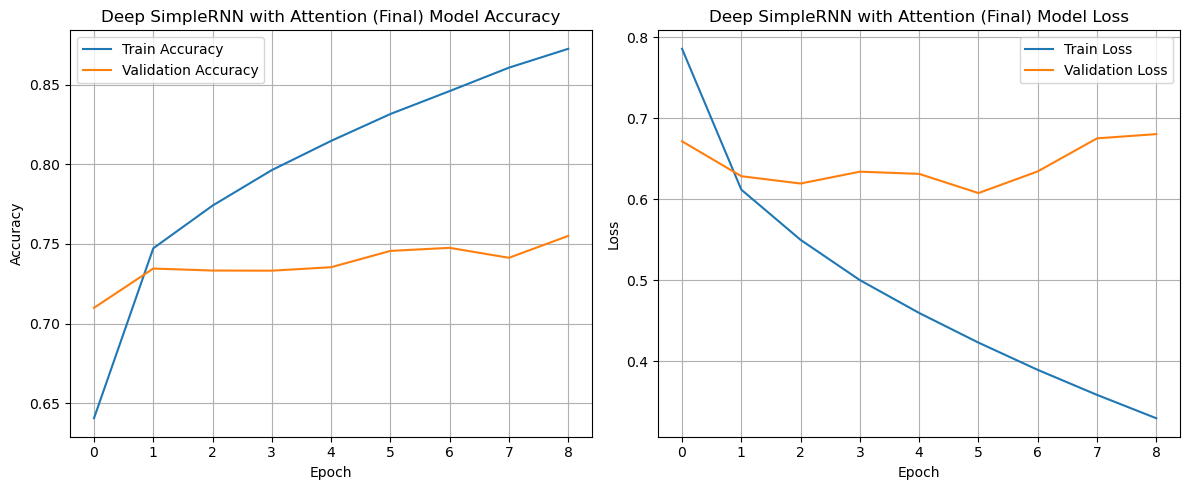

In [46]:
# Final Training with Best Parameters for Deep SimpleRNN
final_rnn_model = create_deep_rnn_model(
    learning_rate=best_rnn_model_params['model__learning_rate'],
    dropout_rate=best_rnn_model_params['model__dropout_rate'],
    rnn_units_1=best_rnn_model_params['model__rnn_units_1'],
    rnn_units_2=best_rnn_model_params['model__rnn_units_2']
)
final_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_rnn_model_params['model__learning_rate']),
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_rnn_model.summary()

history_final_rnn = final_rnn_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10,
    batch_size=best_rnn_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_final_rnn, accuracy_final_rnn = final_rnn_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Deep SimpleRNN Test Loss: {loss_final_rnn:.4f}")
print(f"Final Deep SimpleRNN Test Accuracy: {accuracy_final_rnn:.4f}")
y_pred_final_rnn = np.argmax(final_rnn_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_rnn, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_rnn))
plot_training_history(history_final_rnn, 'Deep SimpleRNN with Attention (Final)')

In [65]:
# Making Predictions on New Comments
def predict_sentiment(comment, model):
    # Preprocess for RNN/LSTM
    seq = tokenizer_rnn_lstm_gru.texts_to_sequences([comment])
    padded_seq = pad_sequences(seq, maxlen=max_len_rnn_lstm_gru, padding='post', truncating='post')
    prediction = model.predict(padded_seq)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    sentiment_label = label_encoder.inverse_transform([predicted_class])[0]
    return sentiment_label

# Example comments for prediction
new_comments = [
    "This video was absolutely fantastic, I loved every second!",
    "The audio quality was terrible, couldn't hear anything.",
    "It's an okay video, nothing groundbreaking but not bad either.",
    "I'm so happy with this content, it's exactly what I needed.",
    "This is the worst thing I've ever seen on YouTube."
]

In [66]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_bilstm_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative


In [58]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_rnn_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative


In [59]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_stacked_lstm_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative
